# 1.先将所有涉及到微博账号的数据爬下来
存入user_info.csv

错误id和对应原因都在error_id.txt中

In [1]:
import pandas as pd
import json
import requests
import csv
import time
from tqdm import tqdm

df = pd.read_csv('dataset/raw_data.csv', encoding='gbk')
# 统计user_id，存为一个list
user_id = df['user_id'].unique().tolist()
print(f'总用户数为：{len(user_id)}')

总用户数为：6906


In [ ]:
import pandas as pd
import json
import requests
import csv
import time
from tqdm import tqdm

def get_html(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36",
        "Referer": "https://weibo.com"
    }
    cookies = {
    	"cookie": "SINAGLOBAL=9352767257598.324.1659632315488; UOR=,,cn.bing.com; MEIQIA_TRACK_ID=2WZGIZXfEq7lkzunkcJYotqxrzZ; MEIQIA_VISIT_ID=2WZGIc1giETiqLlAUTkWDZSsmng; __gpi=UID=00000a3dc5f5845f:T=1698981061:RT=1698981061:S=ALNI_MYnlPtQQ_lnM0iFrku7Xxs8GMuRWg; _ga=GA1.1.1309258020.1698981035; __gads=ID=57f3befbe9279f5b-22b0f1995ae300fd:T=1698981061:RT=1698981064:S=ALNI_Maw6hQXXYznylg-VnXuruG49zu78g; _ga_QZXMWYY4QK=GS1.1.1698981036.1.1.1698981098.60.0.0; _ga_7WMZ8XEWGJ=GS1.1.1698981036.1.1.1698981098.0.0.0; _ga_B61YQPGY9T=GS1.1.1698981036.1.1.1698981098.0.0.0; _ga_DL2CM4NHWS=GS1.1.1698981037.1.1.1698981098.0.0.0; SUBP=0033WrSXqPxfM725Ws9jqgMF55529P9D9W5HYuPrqX_DP6c1Bieh9V3_5JpX5KMhUgL.FoMRShzRe0MEe0e2dJLoI7LSqgx2KXvlxf.t; SCF=AovAOqHf0GuwsstX8fjq3Tzi5B4y7r_pvyqPUl8Ue3kUlik-J8Os10WAIUD3diCEOHpLAHleQ6JG_GaceBct4sI.; SUB=_2A25Ic5OUDeRhGeFG71AZ8ynOyD-IHXVr8KlcrDV8PUNbmtANLU_jkW9NeZByG0r0F_n1-UYG--2SREW1bHCzoWHg; ALF=1704947907; ULV=1702433687064:153:5:4:7177158601798.726.1702433687029:1702385540598; WBPSESS=sVVCqKTXEXkM-rwvkK_5OsIvBzU_dMgeT99NYWAs-Hgs4SGPaxL1RLMTMi-oScbeQKy858yiKR4mo0652LCnzfDroxoKcH7L8GXetAJCoACiyGVFrz8a4F_yi7-Nj-kgSus0r_D8pIwo2K5bSmuMcw==; XSRF-TOKEN=9cAjYH7YVLtIfxJ2xawnbRgn"
    }
    response = requests.get(url, headers=headers, cookies=cookies)
    time.sleep(1)   # 加上延时防止被反爬
    return response.text

title = ['user_id','name', 'description','top_user','followers_count', 'friends_count', 'statuses_count', 'verified', 'verified_reason', 'label']
file_name = "user_info.csv"

def init_csv():
    with open(file_name, "a", encoding="utf-8", newline="")as fi:
        # 添加表头
        fi = csv.writer(fi)
        fi.writerow(title)
def save_data(data):
    with open(file_name, "a", encoding="utf-8", newline="")as fi:
        fi = csv.writer(fi)
        fi.writerow([data[k] for k in title])

def get_data(id):
    url1 = "https://weibo.com/ajax/profile/info?uid={}".format(id)
    url2 = "https://weibo.com/ajax/profile/detail?uid={}".format(id)
    html1 = get_html(url1)
    html2 = get_html(url2)
    responses1 = json.loads(html1)
    data1 = responses1['data']['user']
    responses2 = json.loads(html2)
    data2 = responses2['data']
    
    data = {}   # 新建个字典用来存数据
    data['user_id'] = id  # 用户id
    data['name'] = data1['screen_name']  # 名字
    data['description'] = data1['description']  # 个人简介
    data['followers_count'] = data1['followers_count']  # 粉丝数量
    data['friends_count'] = data1['friends_count']  # 关注数量
    data['statuses_count'] = data1['statuses_count']  # 博文数量
    data['verified'] = data1['verified']  # 是否认证
    try:
        data['top_user'] = data1['top_user']  # 是否为大V 系统自动判定
    except KeyError:
        data['top_user'] = ""
    try:
        data['verified_reason'] = data1['verified_reason']  # 认证信息
    except KeyError:
        data['verified_reason'] = ""
    try:
        label_desc = data2['label_desc']  # 标签
        data['label'] = [label_desc[i]['name'] for i in range(len(label_desc))]
    except KeyError:
        data['label'] = ""
    save_data(data)


if __name__ == '__main__':   
    # 读入csv文件
    df = pd.read_csv('dataset/raw_data.csv', encoding='gbk')
    # 统计user_id，存为一个list
    user_id = df['user_id'].unique().tolist()
    print(f'总用户数为：{len(user_id)}')
    # 初始化csv文件
    init_csv()
    # 遍历user_id，获取数据
    for id in tqdm(user_id):
        try:
            get_data(id)
        except:
            with open('error_id.txt', 'a') as f:
                f.write(str(id) + '\n')
            print(f'出错的id为：{id}')
            continue

# 2.处理user_data.csv
分类依据：

1.官方账号：先根据"是否认证"以及"认证原因"，存在“官方”字眼则判断为官方账号

2.top_user：微博爬下来的用户数据中有一项“top_user”，可以作为分类依据，其相关性质在下面进行了分析

3.高活跃度用户：在之前爬取了每个账号可能有的label，如果存在"热门xx博主 数据飙升" "热点榜第xx名" "昨日(发博xxx)，阅读数xxx，互动数xxx"则是高活跃度用户

处理结果在```user_classify.csv```，包含'user_id', 'followers_count', 'official', 'top_user', 'high_quality'几列，分别是：id，粉丝数，是否是官方账号，是否是top_user，是否是高活跃度用户


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
user_title = ['user_id', 'followers_count', 'official', 'top_user', 'high_quality']
user_file_name = "user_classify.csv"

user_info = pd.read_csv('user_info.csv', encoding='utf-8')

with open(user_file_name, "a", encoding="utf-8", newline="") as fi:
    # 添加表头
    fi = csv.writer(fi)
    fi.writerow(user_title)

for i in tqdm(range(len(user_info))):
    data = {}
    data['user_id'] = user_info['user_id'][i]
    data['followers_count'] = user_info['followers_count'][i]
    if user_info['verified'][i] == True:
        verified_reason = user_info['verified_reason'][i]
        if "官方" in verified_reason:
            data['official'] = 1
        else:
            data['official'] = 0
    else:
        data['official'] = 0
    if user_info['top_user'][i] == 1:
        data['top_user'] = 1
    else:
        data['top_user'] = 0
    labels = user_info['label'][i]
    if "飙升" in labels or "热点榜" in labels or ("阅读数" in labels and "互动数" in labels):
        data['high_quality'] = 1
    else:
        data['high_quality'] = 0
    with open(user_file_name, "a", encoding="utf-8", newline="") as fi:
        fi = csv.writer(fi)
        fi.writerow([data[k] for k in user_title])

  0%|          | 0/6898 [00:00<?, ?it/s]

100%|██████████| 6898/6898 [00:06<00:00, 1121.44it/s]


In [14]:
user = pd.read_csv('user_classify.csv', encoding='utf-8')
high_quality_top_user = len(user[(user['high_quality'] == 1) & (user['top_user'] == 1)])
high_quality_official = len(user[(user['high_quality'] == 1) & (user['official'] == 1)])
official_top_user = len(user[(user['official'] == 1) & (user['top_user'] == 1)])
high_quality_official_top_user = len(user[(user['high_quality'] == 1) & (user['official'] == 1) & (user['top_user'] == 1)])
top_user = len(user[user['top_user'] == 1])
high_quality = len(user[user['high_quality'] == 1])
official = len(user[user['official'] == 1])
pure_user = len(user[(user['high_quality'] == 0) & (user['official'] == 0) & (user['top_user'] == 0)])
print(f'总用户数为：{len(user)}')
print(f'高活跃度账号数为：{high_quality}')
print(f'大V账号数为：{top_user}')
print(f'官方账号数为：{official}')
print(f'普通用户账号数为：{pure_user}')
print(f'高活跃度大V账号数为：{high_quality_top_user}')
print(f'高活跃度官方账号数为：{high_quality_official}')
print(f'官方大V账号数为：{official_top_user}')
print(f'高活跃度官方大V账号数为：{high_quality_official_top_user}')


总用户数为：6898
高活跃度账号数为：1545
大V账号数为：1392
官方账号数为：1487
普通用户账号数为：4408
高活跃度大V账号数为：1077
高活跃度官方账号数为：592
官方大V账号数为：728
高活跃度官方大V账号数为：463


判断一下各类的粉丝数特征

采用数字异常值方法|Numberic Outlier来除去异常值：

1、计算第一四分位数（Q1）及第三四分位数（Q3）

2、计算IQR （IQR = Q3 - Q1）

3、输出正常区间[Q1-1.5IQR，Q3+1.5IQR]


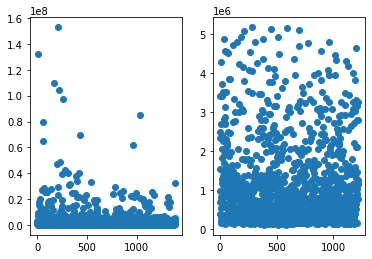

top_user的最大粉丝数为：152819709
top_user的最小粉丝数为：106859
top_user的平均粉丝数为：1124301


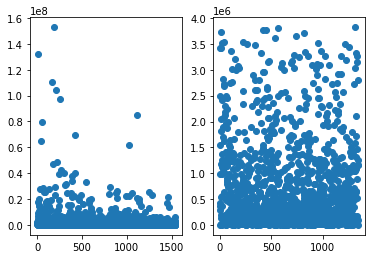

high_quality的最大粉丝数为：152819709
high_quality的最小粉丝数为：5561
high_quality的平均粉丝数为：716971


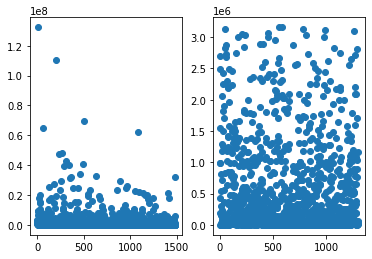

official的最大粉丝数为：132344312
official的最小粉丝数为：18
official的平均粉丝数为：510708


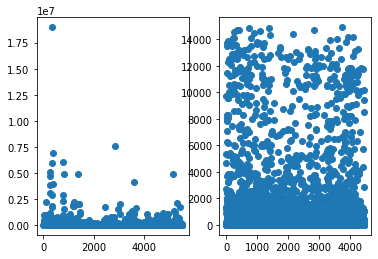

non_top_user的最大粉丝数为：18979797
non_top_user的最小粉丝数为：0
non_top_user的平均粉丝数为：1329


In [5]:
top_user_table = user[user['top_user'] == 1]
top_user_fans = top_user_table['followers_count']

non_top_user_table = user[user['top_user'] == 0]
non_top_user_fans = non_top_user_table['followers_count']

high_quality_table = user[user['high_quality'] == 1]
high_quality_fans = high_quality_table['followers_count']

official_table = user[user['official'] == 1]
official_fans = official_table['followers_count']

def fans_plot(fans, title):
    plt1 = plt.subplot(1,2,1)
    plt1.scatter(range(len(fans)),fans)
    # 数字异常值方法
    Q1 = np.nanpercentile(fans, 25)
    Q3 = np.nanpercentile(fans, 75)
    IQR = Q3 - Q1
    motified_fans = [k for k in fans if k < Q3 + 1.5 * IQR and k > Q1 - 1.5 * IQR]
    plt2 = plt.subplot(1,2,2)
    plt2.scatter(range(len(motified_fans)),motified_fans)
    plt.show()
    print(f"{title}的最大粉丝数为：{max(fans)}")
    print(f"{title}的最小粉丝数为：{min(fans)}")
    print(f"{title}的平均粉丝数为：{int(np.mean(motified_fans))}")

fans_plot(top_user_fans, 'top_user')
fans_plot(high_quality_fans, 'high_quality')
fans_plot(official_fans, 'official')
fans_plot(non_top_user_fans, 'non_top_user')

把xslx文件转成csv处理了，另存为就行



分类：

低活跃度普通账号、低活跃度大V、低活跃度官方账号、低活跃度官方大V、高活跃度普通账号、高活跃度大V、高活跃度官方账号、高活跃度官方大V

对应：0-7


In [35]:
from tqdm import tqdm
user = pd.read_csv('user_classify.csv', encoding='utf-8')
data = {}
for i in tqdm(range(len(user))):
    id = user['user_id'][i]
    top_user = user['top_user'][i]
    official = user['official'][i]
    high_quality = user['high_quality'][i]
    data[id] = top_user * 1 + official * 2 + high_quality * 4

cleaned_data = pd.read_csv('清洗与微博分类后数据.csv', encoding='gbk')
new_column = [0 for i in range(len(cleaned_data))]
cleaned_data.insert(3, 'user_class', new_column)
for i in tqdm(range(len(cleaned_data))):
    id = cleaned_data['user_id'][i]
    cleaned_data['user_class'][i] = data.get(id,0)

# 保存数据
#cleaned_data.to_csv('清洗与微博分类与用户分类后数据.csv', index=True, encoding='gbk')
cleaned_data.to_excel('清洗与微博分类与用户分类后数据.xlsx', index=True)

  0%|          | 0/6898 [00:00<?, ?it/s]

  0%|          | 0/9683 [00:00<?, ?it/s]C:\Users\yyj\AppData\Local\Temp\ipykernel_18524\1839792644.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['user_class'][i] = data.get(id,0)
C:\Users\yyj\AppData\Local\Temp\ipykernel_18524\1839792644.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['user_class'][i] = data.get(id,0)
C:\Users\yyj\AppData\Local\Temp\ipykernel_18524\1839792644.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re